In [1]:
from __future__ import print_function

from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import pylab as plt

Using TensorFlow backend.


In [0]:
# @title Plot losses

import tensorflow as tf
from IPython.display import clear_output
import pylab as plt


class PlotLosses(tf.keras.callbacks.Callback):
    def __init__(self, title=''):
        self.title = title

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        if self.i < self.params['epochs']:
            clear_output(wait=True)

            plt.plot(self.x, self.losses, label="training")
            plt.plot(self.x, self.val_losses, label="validation")
            plt.xlabel('No of epochs')
            plt.ylabel('Loss')
            plt.title(self.title)
            plt.legend()
            plt.show()

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# @title Raw data import and sorting

import os
data_root = '/content/drive/My Drive/Colab Notebooks/Data'

n_positive = len(os.listdir(data_root+'/pos/child_context'))
n_negative = len(os.listdir(data_root+'/neg/child_context'))

files_pos_ch = os.listdir(data_root+'/pos/child_context')
files_pos_pa = os.listdir(data_root+'/pos/parent_context')
files_pos_ch.sort()
files_pos_pa.sort()

files_neg_ch = os.listdir(data_root+'/neg/child_context')
files_neg_pa = os.listdir(data_root+'/neg/parent_context')
files_neg_ch.sort()
files_neg_pa.sort()

In [0]:
# @title Finding lenght of the longest sentence (18)

m1 = np.zeros(n_positive)
m2 = np.zeros(n_positive)
for i in range(n_positive):
    temp1 = np.load(data_root+'/pos/child_context/'+files_pos_ch[i])
    temp2 = np.load(data_root+'/pos/parent_context/'+files_pos_pa[i])
    m1[i] = temp1.shape[0]
    m2[i] = temp2.shape[0]

m3 = np.zeros(n_negative)
m4 = np.zeros(n_negative)
for i in range(n_negative):
    temp1 = np.load(data_root+'/neg/child_context/'+files_neg_ch[i])
    temp2 = np.load(data_root+'/neg/parent_context/'+files_neg_pa[i])
    m3[i] = temp1.shape[0]
    m4[i] = temp2.shape[0]

print(np.min(m1), np.max(m1))
print(np.min(m2), np.max(m2))
print(np.min(m3), np.max(m3))
print(np.min(m4), np.max(m4))

6.0
12.0
5.0
18.0


In [0]:
# @title Dataset preparation (padding sentences with zeros up to 18 tokens)

X = np.zeros((n_positive+n_negative,2,18,300)) # 2 текста, максимум 18 токенов, 300 элементов в векторе

for i in range(n_positive):
    ch = np.load(data_root+'/pos/child_context/'+files_pos_ch[i])
    pa = np.load(data_root+'/pos/parent_context/'+files_pos_pa[i])
    
    ch_shape = ch.shape
    pa.shape = pa.shape

    X[i,0,:ch.shape[0],:ch.shape[1]] = ch
    X[i,1,:pa.shape[0],:pa.shape[1]] = pa

for i in range(n_negative):
    ch = np.load(data_root+'/neg/child_context/'+files_neg_ch[i])
    pa = np.load(data_root+'/neg/parent_context/'+files_neg_pa[i])
    
    ch_shape = ch.shape
    pa.shape = pa.shape

    X[n_positive+i,0,:ch.shape[0],:ch.shape[1]] = ch
    X[n_positive+i,1,:pa.shape[0],:pa.shape[1]] = pa

y = np.zeros(n_positive+n_negative)
y[:n_positive] = 1

In [0]:
# @title Saving dataset

np.save(data_root+'/X.npy', X)
np.save(data_root+'/y.npy', y)

print(X.shape)
print(y.shape)

In [4]:
# @title Loading dataset

X = np.load('/content/drive/My Drive/Colab Notebooks/Data/X.npy')
y = np.load('/content/drive/My Drive/Colab Notebooks/Data/y.npy')

print(X.shape)
print(y.shape)

(6472, 2, 18, 300)
(6472,)


In [0]:
# @title Splitting dataset 80 / 10 / 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                random_state=42)

In [0]:
# @title Constants

# Embedding
embedding_size = 300

# Convolution
kernel_size = 3
filters = 32
pool_size = 2

# LSTM
lstm_output_size = 8

# Training
batch_size = 64
epochs = 100

In [7]:
# @title Base network

txt_in = Input(shape=X_train.shape[2:]) # (18, 300)
# n_layer = Embedding(max_features, embedding_size, input_length=maxlen)(txt_in)
n_layer = Dropout(0.2)(txt_in)
n_layer = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(n_layer)
n_layer = MaxPooling1D(pool_size=pool_size)(n_layer)
n_layer = LSTM(lstm_output_size)(n_layer)

base_model = Model(inputs = [txt_in], outputs = [n_layer], 
                   name = 'BaseModelCNN-LSTM')
base_model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "BaseModelCNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18, 300)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 32)            28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
Total params: 30,144
Trainable params: 30,144
Non-trainable params: 0
_________________________________________________________

In [8]:
# @title Siamese network

from keras.layers import concatenate

txt_a_in = Input(shape = X_train.shape[2:], name = 'Text_A_Input')
txt_b_in = Input(shape = X_train.shape[2:], name = 'Text_B_Input')

txt_a_feat = base_model(txt_a_in)
txt_b_feat = base_model(txt_b_in)

combined_features = concatenate([txt_a_feat, txt_b_feat], 
                                name = 'merge_features')
# combined_features = Dense(8, activation = 'linear')(combined_features)
# combined_features = BatchNormalization()(combined_features)
# combined_features = Activation('relu')(combined_features)
# combined_features = Dense(4, activation = 'linear')(combined_features)
# combined_features = BatchNormalization()(combined_features)
# combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)

hypernimy_model = Model(inputs = [txt_a_in, txt_b_in], 
                        outputs = [combined_features], 
                        name = 'Hypernimy_Model')
hypernimy_model.summary()

Model: "Hypernimy_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_A_Input (InputLayer)       (None, 18, 300)      0                                            
__________________________________________________________________________________________________
Text_B_Input (InputLayer)       (None, 18, 300)      0                                            
__________________________________________________________________________________________________
BaseModelCNN-LSTM (Model)       (None, 8)            30144       Text_A_Input[0][0]               
                                                                 Text_B_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 16)           0           BaseModelCNN-LSTM[1

In [9]:
# @title Metrics and optimization

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

hypernimy_model.compile(optimizer='adam', loss = 'binary_crossentropy', 
                        metrics = ['acc', f1_m, precision_m, recall_m])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


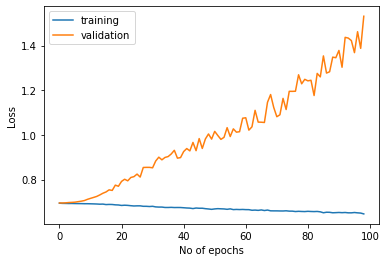

Epoch 100/100
648/648 [==============================] - 0s 330us/step
loss 1.392332347822778
acc 0.18055555555555555
f1_m 0.1407458348038756
precision_m 0.1482785259499962
recall_m 0.13602523340119255


In [10]:
# @title Training and validation

print('Train...')
hypernimy_model.fit([X_train[:,0],X_train[:,1]], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[PlotLosses()],
          validation_data=([X_val[:,0],X_val[:,1]], y_val))

metrics = hypernimy_model.evaluate([X_test[:,0],X_test[:,1]], y_test,
                                   batch_size=batch_size)
metrics_names = hypernimy_model.metrics_names

for name, metric in zip(metrics_names, metrics):
    print(name, metric)